# **Fifa 21 Dataset**

> - Goal of this dataset is to classify a players position based on their attributes


> - we will predict a players position in a test dataset using K nearest neighbors and logistic regression and compare the models







In [59]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib as mpl
from matplotlib import  pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from   sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_validate

### **A) *Brief Exploration of Dataset***

loading data from google drive

In [60]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
%cd /content/drive/My Drive/MLtermProj/FifaDataSet
%pwd
%ls

/content/drive/My Drive/MLtermProj/FifaDataSet
Bibliography.gdoc  FaheemOmar_Dataset2.ipynb  players_21.csv


In [62]:
df = pd.read_csv('players_21.csv')

Printing the head of the dataset and general aspects of Dataset

In [63]:
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,...,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,...,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,...,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,...,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...",LW,10.0,NaN,2017-08-03,2022.0,NaN,NaN,91.0,85.0,86.0,94.0,36.0,59.0,NaN,...,51,36,87,90,92,93,NaN,30,29,9,9,15,15,11,84+3,84+3,84+3,90+0,89+0,89+0,89+0,90+0,90+1,90+1,90+1,90+1,83+3,83+3,83+3,90+1,67+3,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3


In [64]:
print(df.shape,"\n")
print(df.axes,"\n")
# the data type of each column.
print(df.dtypes)


(18944, 106) 

[RangeIndex(start=0, stop=18944, step=1), Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club_name',
       ...
       'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object', length=106)] 

sofifa_id      int64
player_url    object
short_name    object
long_name     object
age            int64
               ...  
lb            object
lcb           object
cb            object
rcb           object
rb            object
Length: 106, dtype: object


we can see that in this dataset we have nearly 19,000 player samples with over a 100 attributes for them

In [65]:
df.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,18944.000000,18944.000000,18944.000000,18944.000000,18719.000000,18944.000000,18944.000000,1.894400e+04,18944.000000,18944.000000,18944.000000,18944.000000,1.794900e+04,18719.000000,18719.000000,1127.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,0.0,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000
mean,226242.402872,25.225823,181.190773,75.016892,1.357070,65.677787,71.086729,2.224813e+06,8675.852513,1.091850,2.936603,2.363017,4.296353e+06,20.589668,2021.983332,12.029281,67.668110,52.274954,57.139434,62.455430,51.316292,64.458988,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,49.612859,45.796083,51.874578,58.705448,42.669552,55.546400,47.187289,42.356155,52.653030,58.482791,64.285103,64.326489,63.333193,61.609428,63.918549,57.752798,64.590530,62.596020,64.742927,46.758763,55.488862,46.250000,50.255807,53.828231,48.050412,57.978674,NaN,47.581767,45.546505,16.446052,16.236486,16.103357,16.225982,16.551309
std,27171.091056,4.697354,6.825672,7.057140,0.739327,7.002278,6.109985,5.102486e+06,19654.774894,0.361841,0.667132,0.766469,1.005968e+07,17.057568,1.260426,6.674627,10.984862,13.991421,10.273655,10.048706,16.405179,9.746706,7.710474,7.328945,7.575184,8.126601,10.714523,8.565969,18.153057,19.592269,17.321709,14.572383,17.661569,18.787112,18.231204,17.239561,15.205281,16.598040,14.926452,14.689422,14.625189,9.112954,14.075215,13.330631,11.888479,15.878793,12.519775,19.305319,17.203045,20.738106,19.443738,13.724072,15.671721,12.118390,NaN,21.402461,20.953997,17.577332,16.845480,16.519399,17.017341,17.878121
min,41.000000,16.000000,155.000000,50.000000,1.000000,47.000000,47.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,9.000000e+03,1.000000,2020.000000,1.000000,25.000000,16.000000,25.000000,25.000000,15.000000,28.000000,45.000000,43.000000,35.000000,44.000000,12.000000,38.000000,6.000000,3.000000,5.000000,7.000000,3.000000,5.000000,4.000000,5.000000,5.000000,5.000000,13.000000,12.000000,14.000000,24.000000,12.000000,18.000000,15.000000,12.000000,16.000000,4.000000,9.000000,3.000000,2.000000,9.000000,6.000000,12.000000,NaN,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,210030.500000,21.000000,176.000000,70.000000,1.000000,61.000000,67.000000,3.000000e+05,1000.000000,1.000000,3.000000,2.000000,5.250000e+05,9.000000,2021.000000,6.000000,62.000000,42.000000,50.000000,57.000000,36.000000,58.000000,60.000000,58.000000,57.000000,60.000000,28.000000,57.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,35.000000,31.000000

With the .describe() attribute we can view the mean, std, min/max value, as well as the percentiles of each numerical attribute. 

In [66]:
df.describe().shape

(8, 62)

In our dataframe we can show that we have 44 categorical variables such as work rate, player position, preffered foot, and player tags. As well as our target variable: Player Position

We see that some columns werent able to web scraped correctly so we have certain columns full od Nans or invalid entries. We also need to label encode my categorical variables. Lastly we will need separate our test data and training data out of the dataset. 

### **B & C) *Pre Processing of DataSet and Feature Extraction***

Were going to need to:


> - Replace Nan values with feature mean


> - Drop redudant feautures (ex D.O.B for age)


> - Label encode categorical variables and target variable(player position)



> - Mean center the dataset 


















*First we drop the redundant features*

were going to drop the defending marking and loaned from variable as it is a busted feature with all Nan values as previously shown. Also were going to drop the sofifa id, player_url, short name, date of birth, club name and league name as the league rank does a numerical way of describing the club name and league, real face, nation number, player tags, nation jersey number, contract valid until.

In [67]:
print(df['defending_marking'])
print(df['loaned_from'])
dropping= ['defending_marking','player_url','sofifa_id', 'short_name','dob','club_name','league_name','real_face','loaned_from','contract_valid_until','nation_position','nation_jersey_number', ]

df=df.drop(columns=dropping)
print(df.head(10))


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
18939   NaN
18940   NaN
18941   NaN
18942   NaN
18943   NaN
Name: defending_marking, Length: 18944, dtype: float64
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
18939    NaN
18940    NaN
18941    NaN
18942    NaN
18943    NaN
Name: loaned_from, Length: 18944, dtype: object
                             long_name  age  height_cm  ...    cb   rcb    rb
0       Lionel Andrés Messi Cuccittini   33        170  ...  52+3  52+3  62+3
1  Cristiano Ronaldo dos Santos Aveiro   35        187  ...  54+3  54+3  61+3
2                            Jan Oblak   27        188  ...  33+3  33+3  32+3
3                   Robert Lewandowski   31        184  ...  60+3  60+3  61+3
4        Neymar da Silva Santos Júnior   28        175  ...  49+3  49+3  62+3
5                      Kevin De Bruyne   29        181  ...  69+3  69+3  75+3
6                 Kylian Mbappé Lottin   21        178  ...  55+3  55+3  63+

In [68]:
#here is the dataset with the dropped columns
print('The new shape of the data is ',df.shape)


The new shape of the data is  (18944, 94)


In [69]:
df.head()

,long_name,age,height_cm,weight_kg,nationality,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,release_clause_eur,player_tags,team_position,team_jersey_number,joined,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,Lionel Andrés Messi Cuccittini,33,170,72,Argentina,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,2004-07-01,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,88,...,94,44,40,93,95,75,96,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,Cristiano Ronaldo dos Santos Aveiro,35,187,83,Portugal,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,2018-07-10,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,86,...,93,63,29,95,82,84,95,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,Jan Oblak,27,188,87,Slovenia,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,159400000.0,NaN,GK,13.0,2014-07-16,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,13,...,12,34,19,11,65,11,68,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,Robert Lewandowski,31,184,80,Poland,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,2014-07-01,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,89,...,85,81,49,94,79,88,88,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,Neymar da Silva Santos Júnior,28,175,68,Brazil,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,166500000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...",LW,10.0,2017-08-03,91.0,85.0,86.0,94.0,36.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Injury Prone, Flair, Speed Dribbler (AI), Outs...",85,87,62,87,87,...,84,51,36,87,90,92,93,30,29,9,9,15,15,11,84+3,84+3,84+3,90+0,89+0,89+0,89+0,90+0,90+1,90+1,90+1,90+1,83+3,83+3,83+3,90+1,67+3,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3


*Now we begin to deal with our nans*


> - We first notice that certain attributes from pace gk positioning have Nan values specific to field players and goalkeepers, secondly not every player has player traits, player tags, joined as the more famous players have those added by the Fifa development team



> So were gonna drop the player traits, player tags and joined and then replace the Nan values in that range of features previously mentioned with 0 as the value



> we are also going to drop team positions variable as its format is difficult to translate into numerical values as well as the fact that it is redundant to player positions.
    were also gonna drop nationality because that wont have any sort of correlation to how a player finds his position


    We will lastly drop the variables from ls to rb as those are conditional variables that are in string format of (rating + value) where the value corressponds how much the overall were to improve if moved to that position










In [70]:
## dropping player tags and traits
df= df.drop(columns=['player_traits', 'player_tags','joined','body_type','team_position','nationality'])
df= df.drop(columns=df.loc[:,'ls':'rb'])
print(df.shape)

(18944, 62)


In [71]:
## replacing NAN values of attributes in range of pace to gk positioning 
df.loc[:, 'pace':'gk_positioning'] = df.loc[:, 'pace':'gk_positioning'].fillna(0)
print(df.loc[:, 'pace':'gk_positioning'])

       pace  shooting  passing  ...  gk_reflexes  gk_speed  gk_positioning
0      85.0      92.0     91.0  ...          0.0       0.0             0.0
1      89.0      93.0     81.0  ...          0.0       0.0             0.0
2       0.0       0.0      0.0  ...         90.0      52.0            90.0
3      78.0      91.0     78.0  ...          0.0       0.0             0.0
4      91.0      85.0     86.0  ...          0.0       0.0             0.0
...     ...       ...      ...  ...          ...       ...             ...
18939  63.0      37.0     50.0  ...          0.0       0.0             0.0
18940  58.0      23.0     26.0  ...          0.0       0.0             0.0
18941  51.0      25.0     29.0  ...          0.0       0.0             0.0
18942  61.0      35.0     48.0  ...          0.0       0.0             0.0
18943  65.0      37.0     49.0  ...          0.0       0.0             0.0

[18944 rows x 12 columns]


Now we are going to label encode the categorical variables in order to continue replace the rest of the nans with the mean of the column

In [72]:
df.head()

,long_name,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,Lionel Andrés Messi Cuccittini,33,170,72,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,138400000.0,10.0,85.0,92.0,91.0,95.0,38.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,Cristiano Ronaldo dos Santos Aveiro,35,187,83,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,75900000.0,7.0,89.0,93.0,81.0,89.0,35.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
2,Jan Oblak,27,188,87,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,159400000.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,90.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,78,90,90
3,Robert Lewandowski,31,184,80,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,132000000.0,9.0,78.0,91.0,78.0,85.0,43.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10
4,Neymar da Silva Santos Júnior,28,175,68,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,166500000.0,10.0,91.0,85.0,86.0,94.0,36.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11


In [73]:
print('player positions',len(df['player_positions'].unique()))
print('preferred foot',df['preferred_foot'].unique())
print('workrate',df['work_rate'].unique())

catVars= ['preferred_foot','work_rate']

player positions 611
preferred foot ['Left' 'Right']
workrate ['Medium/Low' 'High/Low' 'Medium/Medium' 'High/Medium' 'High/High'
 'Medium/High' 'Low/High' 'Low/Medium' 'Low/Low']


we now run into an issue with the way the data was formatted during web scraping for the player position as players often can play many various positions in a position pool. We need to reduce that by grouping players by the position pools of goalkeeper, midfielder, defender, and foward.

we know that certain distinctions need to be made for players that can play LM and LW and CF and CAM and LB/LWB and LM as those are very similar position that are in two different position pools.

Well first label encode the other two first using the sklearn label encoder. we will use the .fit method to fit the data in to the label encoder which then we call the .transform method which then label encodes our data from 0 to #of unique categories

In [74]:
#label encoding
le = sk.preprocessing.LabelEncoder()
for col in catVars:
  le.fit(df.loc[:,col])
  df.loc[:,col]= le.transform(df.loc[:,col])

df.head()

,long_name,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,Lionel Andrés Messi Cuccittini,33,170,72,1.0,93,93,67500000,560000,"RW, ST, CF",0,5,4,4,7,138400000.0,10.0,85.0,92.0,91.0,95.0,38.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,Cristiano Ronaldo dos Santos Aveiro,35,187,83,1.0,92,92,46000000,220000,"ST, LW",1,5,4,5,1,75900000.0,7.0,89.0,93.0,81.0,89.0,35.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
2,Jan Oblak,27,188,87,1.0,91,93,75000000,125000,GK,1,3,3,1,8,159400000.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,90.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,78,90,90
3,Robert Lewandowski,31,184,80,1.0,91,91,80000000,240000,ST,1,4,4,4,2,132000000.0,9.0,78.0,91.0,78.0,85.0,43.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10
4,Neymar da Silva Santos Júnior,28,175,68,1.0,91,91,90000000,270000,"LW, CAM",1,5,5,5,2,166500000.0,10.0,91.0,85.0,86.0,94.0,36.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11


we have to parse the player positions and keep the first position in the parsed array

In [75]:
#parsing

for  i in range(len(df['player_positions'])):
  df['player_positions'][i]= df['player_positions'][i].split(',')
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,long_name,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,Lionel Andrés Messi Cuccittini,33,170,72,1.0,93,93,67500000,560000,"[RW, ST, CF]",0,5,4,4,7,138400000.0,10.0,85.0,92.0,91.0,95.0,38.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,Cristiano Ronaldo dos Santos Aveiro,35,187,83,1.0,92,92,46000000,220000,"[ST, LW]",1,5,4,5,1,75900000.0,7.0,89.0,93.0,81.0,89.0,35.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
2,Jan Oblak,27,188,87,1.0,91,93,75000000,125000,[GK],1,3,3,1,8,159400000.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,90.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,78,90,90
3,Robert Lewandowski,31,184,80,1.0,91,91,80000000,240000,[ST],1,4,4,4,2,132000000.0,9.0,78.0,91.0,78.0,85.0,43.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10
4,Neymar da Silva Santos Júnior,28,175,68,1.0,91,91,90000000,270000,"[LW, CAM]",1,5,5,5,2,166500000.0,10.0,91.0,85.0,86.0,94.0,36.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11


In [ ]:
#now the player position grouping encoding
#
# gk=0
# defenders= 1
# midfielders= 2
# fowards = 3

for i in range(len(df['player_positions'])):
  if (df['player_positions'][i][0] == 'GK'):
    df['player_positions'][i] = 0
  ##Fowards
  elif (df['player_positions'][i][0] == ('CF')):
    df['player_positions'][i] = 3
  elif (df['player_positions'][i][0] == ('ST')):
    df['player_positions'][i] = 3
  elif (df['player_positions'][i][0] == ('RW')):
    df['player_positions'][i] = 3
  elif (df['player_positions'][i][0] == ('LW')):
    df['player_positions'][i] = 3
  ##midfield
  elif (df['player_positions'][i][0] == 'CM'):
    df['player_positions'][i] = 2
  elif (df['player_positions'][i][0] == 'CAM'):
    df['player_positions'][i] = 2
  elif (df['player_positions'][i][0] == 'CDM'):
    df['player_positions'][i] = 2
  elif (df['player_positions'][i][0] == 'LM'):
    df['player_positions'][i] = 2
  elif (df['player_positions'][i][0] == 'RM'):
    df['player_positions'][i] = 2
  ##defense
  elif (df['player_positions'][i][0] == 'RB'):
    df['player_positions'][i] = 1
  elif (df['player_positions'][i][0] == 'LB'):
    df['player_positions'][i] = 1
  elif (df['player_positions'][i][0] == 'RWB'):
    df['player_positions'][i] = 1
  elif (df['player_positions'][i][0] == 'CB'):
    df['player_positions'][i] = 1
  elif (df['player_positions'][i][0] == 'LWB'):
    df['player_positions'][i] = 1




In [77]:
df['player_positions'].unique()
dfnames=df['long_name']
df=df.drop(columns=['long_name'])

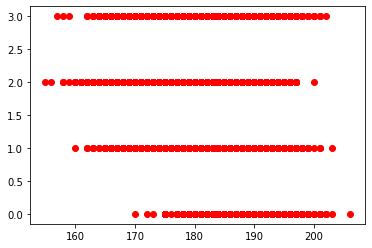

In [78]:
xx= df['height_cm']
yy= df['player_positions']

plt.plot(xx, yy, 'o', color='red');

*Replacing the rest of the NANS with the column mean*

In [79]:
## nan replacement
for i in df.columns:
  df[i]= df[i].fillna(df[i].mean())


###  ***D) Processing of each dataset using three different machine learning methods (LDA, Logistic Regression, KNN, K-Fold Cross Validation)***

In [80]:
print(df.shape)
dfTrain=df.iloc[0:14208,:]  
dfTest=df.iloc[14208:-1,:] 

dfTrainX= dfTrain.drop(columns=['player_positions'])
dfTrainY= dfTrain['player_positions']

dfTestX= dfTest.drop(columns=['player_positions'])
dfTestY= dfTest['player_positions']

(18944, 61)


We now create the traininf set and test set with 75% of the samples in the training set and 25% of the data in the Test set

We will now build our K nearest neighbors classifier to predict a players position and here we see that we get a fairly low average accuracy for our predictions for each K value

In [81]:
for i in range(10):
  neighbor=  KNeighborsClassifier(n_neighbors=i+1)
  neighbor.fit(dfTrainX,dfTrainY)
  pred= neighbor.predict(dfTestX)
  print('Mean accuracy: ',neighbor.score(dfTestX,dfTestY))
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_val_score(neighbor, dfTrainX, dfTrainY, scoring='accuracy', cv=cv, n_jobs=-1)

  print(' fold mean: ', scores)
  print('F1 Score for each k: ', i+1)
  print(f1_score(dfTestY, KNeighborsClassifier(n_neighbors=i+1).fit(dfTrainX,dfTrainY).predict(dfTestX), average=None).mean())

  outVal = neighbor.score(dfTestX, dfTestY)
  print('Score: {:.2%}'.format(outVal))


Mean accuracy:  0.32439281942977827
 fold mean:  [0.4729064  0.4729064  0.48416608 0.46868403 0.47712878 0.47783251
 0.49894441 0.47361013 0.47183099 0.49929577]
F1 Score for each k:  1
0.2988704354830233
Score: 32.44%
Mean accuracy:  0.27243928194297784
 fold mean:  [0.43420127 0.434905   0.45109078 0.44053483 0.43842365 0.44546094
 0.43631246 0.44968332 0.44647887 0.44295775]
F1 Score for each k:  2
0.2278983816647466
Score: 27.24%
Mean accuracy:  0.29271383315733895
 fold mean:  [0.41590429 0.408867   0.4278677  0.41801548 0.4208304  0.41027445
 0.43420127 0.42575651 0.41478873 0.41619718]
F1 Score for each k:  3
0.2572667340927397
Score: 29.27%
Mean accuracy:  0.28954593453009503
 fold mean:  [0.40042224 0.43560873 0.4278677  0.43631246 0.4278677  0.42294159
 0.44053483 0.4208304  0.41267606 0.40633803]
F1 Score for each k:  4
0.25058490564708175
Score: 28.95%
Mean accuracy:  0.2969376979936642
 fold mean:  [0.42294159 0.43560873 0.42505278 0.42434905 0.41027445 0.41731175
 0.42716

We can see that despite k value we can get an accuracy score with cross validtion of 48% but we chose k=1 bc it has the largest mean accuracy

In [82]:
# confusion matrix
print('Here is the confusion matrix for KNN')
print(confusion_matrix(dfTestY, KNeighborsClassifier(n_neighbors=1).fit(dfTrainX,dfTrainY).predict(dfTestX), labels=[0, 1, 2,3]))



Here is the confusion matrix for KNN
[[309 286  79  20]
 [429 707 184  58]
 [479 716 398 115]
 [255 401 177 122]]


Our accuracy and F1 scores show that our model performs poorly with our optimized parameters.

**Now onto the Logistic Regression model**

We observe that logistic regression is a binary classifier thus we must use the one vs many approach for our classification and creating 4 logistic regression classifers, the logistic classifier with the highest probability is the predicted class

In [83]:
model1 = LogisticRegression(solver = 'lbfgs')
# Fit on training set only.
# Apply transform to both the training set and the test set.


model1.fit(dfTrainX, dfTrainY)
yy_pred = model1.predict(dfTestX)

count_misclassified = (dfTestY != yy_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(dfTestY, yy_pred)
print('Accuracy: {:.2f}'.format(accuracy))

outVal1 = model1.score(dfTestX, dfTestY)
print('Score: {:.2%}'.format(outVal1),'\n')


Misclassified samples: 3170
Accuracy: 0.33
Score: 33.05% 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We can see similarily to the KNN model, our logistic regression classifier performs poorly as well. Well go ahead and try a k=10 fold cross validation to see if we can get a higher accuracy score.

In [84]:
  cv2 = KFold(n_splits=10, random_state=1, shuffle=True)
  scores2 = cross_val_score(model1, dfTrainX, dfTrainY, scoring='accuracy', cv=cv2, n_jobs=-1).mean()

  print(' fold mean: ', scores2)
  print('F1 Score: ')
  print(f1_score(dfTestY,model1.predict(dfTestX) , average=None).mean())


 fold mean:  0.3898492432427075
F1 Score: 
0.19691008351383815


now the confusion matrix:


In [85]:
# confusion matrix
print('Here is the confusion matrix for Logistic Regression')
print(confusion_matrix(dfTestY, model1.predict(dfTestX), labels=[0, 1, 2,3]))



Here is the confusion matrix for Logistic Regression
[[  0 327 367   0]
 [  0 586 792   0]
 [  0 729 979   0]
 [  0 424 531   0]]


Now onto the LDA Classifier:

In [86]:
lda = LDA()
lda.fit(dfTrainX, dfTrainY)
    #Compute classification error
outVal = lda.score(dfTestX, dfTestY)
print('Score: {:.2%}'.format(outVal))

Score: 91.72%


suprisingly the LDA classfier does really well so now well look at the F1 score and confusion matrix to further validate our reading

In [87]:

print('F1 Score : ')
print(f1_score(dfTestY, lda.predict(dfTestX) , average=None).mean())
print(confusion_matrix(dfTestY, lda.predict(dfTestX), labels=[0, 1, 2,3]))


F1 Score : 
0.9250177963596374
[[ 694    0    0    0]
 [   0 1268  109    1]
 [   0   37 1601   70]
 [   0    1  174  780]]


###  ***E) Comparative Analysis of each dataset using three different machine learning methods (LDA, Logistic Regression, KNN, K-Fold Cross Validation)***

After our analysis of this dataset with the classification models used, it is clear that the model that should be chosen for this problem set is the LDA model. The LDA model boasts a score of ~92% while the KNN model and the Logistic Regression models have a score around 33%.

Below are  the confusion matrices 

In [88]:
##KNN
# confusion matrix
print('KNN confusion Matrix')
print(confusion_matrix(dfTestY, KNeighborsClassifier(n_neighbors=1).fit(dfTrainX,dfTrainY).predict(dfTestX), labels=[0, 1, 2,3]),'\n')

## logistic Regression
print('Logistic Regression confusion Matrix')
print(confusion_matrix(dfTestY, model1.predict(dfTestX), labels=[0, 1, 2,3]),'\n')
##LDA
print('LDA confusion Matrix')
print(confusion_matrix(dfTestY, lda.predict(dfTestX), labels=[0, 1, 2,3]))

KNN confusion Matrix
[[309 286  79  20]
 [429 707 184  58]
 [479 716 398 115]
 [255 401 177 122]] 

Logistic Regression confusion Matrix
[[  0 327 367   0]
 [  0 586 792   0]
 [  0 729 979   0]
 [  0 424 531   0]] 

LDA confusion Matrix
[[ 694    0    0    0]
 [   0 1268  109    1]
 [   0   37 1601   70]
 [   0    1  174  780]]


The Logistic regression model is by far the worst out of the three due to its higher computational need compared to the other models. 

###  ***F) Ethical Issues***

Fortunately for this problem and dataset there are not as dangerous ethical dilemmas compared to others. With the LDA model performing that well it could be used to predict persons postion on the field which could ultimately clash against what a person wants. After all soccer is just a game so if a person wants to play a position of their liking, they should be able to and not forced to listen to a computer.

###  ***G) Bibliography***

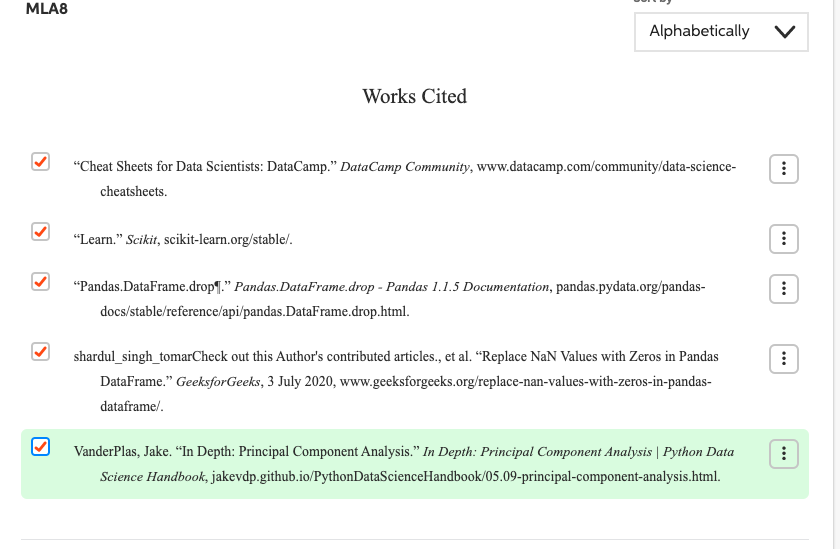